# Neural Network for Numerical Integration on the Kuramoto–Sivashinsky (KS) PDE

This notebook contains the solution to part (a) and (b) of exercise 6.1 for the KS equations.

## (a) - NN for the KS system

The **Kuramoto–Sivashinsky equation** (or flame equation) is a fourth-order nonlinear partial differential equation. It is named after Yoshiki Kuramoto and Gregory Sivashinsky, who derived the equation in the late 1970s to model the diffusive–thermal instabilities in a laminar flame front. It is known for its **chaotic behavior**.

The 1-D version of the KS equation can be written as:
$$ u_t + u_{xx} + u_{xxxx} + \frac{1}{2}u_x^2 = 0 $$

Data of the KS system is downloaded and imported from the resource site at https://databookuw.com/

In [1]:
# Import the necessary libraries.
import numpy as np
import scipy.io
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Import plotting libraries and tools.
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# Import data.
# get the right path to the data.
data_path = os.path.join( os.path.abspath("") , "../DATA/kuramoto_sivishinky.mat" )
# load the data.
data = scipy.io.loadmat( data_path )
uu = data["uu"].T
x = data["x"].squeeze()
tt = data["tt"].squeeze()

# save the important dimensions.
t_len = len(tt)
x_len = len(x)
print("NUMBER OF TIME-STEPS:", t_len)
print("NUMBER OF SPACE-POINTS:", x_len)

NUMBER OF TIME-STEPS: 251
NUMBER OF SPACE-POINTS: 1024


## Dataset

The data can be interpreted as a temporal-sequence of $251$ vectors (labelled throught $t_0,...,t_{250}$), each composed of $1024$ space points (labelled throught $x_0,...,x_{1024}$). This means that, if $uu$ is a matrix of dimension $(251 \times 1024)$, given the column $uu^{(j)}$, we want to predict column $uu^{(j+\Delta j)}$. 

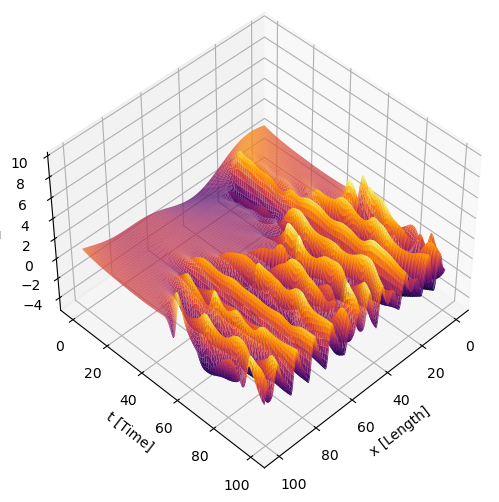

In [3]:
# Plot the data.
fig = plt.figure( figsize = ( 6 , 6 ) )
ax = fig.add_subplot( 1 , 1 , 1 , projection = '3d' )
X , T = np.meshgrid( x , tt )
surf = ax.plot_surface( X , T , uu , cmap = 'inferno' , rstride = 3, cstride = 3, antialiased = True )
ax.set_xlabel('x [Length]')
ax.set_ylabel('t [Time]')
ax.set_zlabel('uu')
ax.set_zlim( -5 , 10 )
ax.view_init( 45 , 45 )
plt.show()

First, we must prepare the dataset:
- The input dataset, $IN$, will correspond to a matrix of dimension $((251 - \Delta j) \times 1024)$, which contains the coulmns from $uu^{(0)}$ to $uu^{(250 - \Delta j)}$. 
- The labels (or output), $OUT$, will be composed of a matrix with same dimension, but whose columns span from $uu^{(\Delta j)}$ to $uu^{(250)}$. 

We tried to implement two different experiments:
- CASE 1: The network takes as input $uu^{(j)},...,uu^{(j+\Delta j -1)}$ and gives back as its output $uu^{(j+\Delta j)}$. In this case the data pair is composed of a tuple and a vector ([$uu^{(j)},...,uu^{(j+\Delta j-1)}$],$uu^{(j+\Delta j)}$).
- CASE 2: The network takes as input $uu^{(j)}$ and gives back as its output $uu^{(j+\Delta j)}$. Each pair of columns ($uu^{(j)}$,$uu^{(j+\Delta j)}$) is a data-pair.


### CASE 1
Create the data pairs.

In [4]:
# Choose a DELTA T (from 0 to 251)
DT = 10

# divide the dataset between input (past) and output (future).
past = uu[ : ( t_len - DT ) , : ] 
future = uu[ DT : (t_len) , : ] 

# define IN and OUT coherently with their description.
IN = np.zeros(( t_len - DT , DT , x_len ))
OUT = future

for i in range( 0 , t_len - DT , 1 ):
    IN[i] = uu[ i : i + DT , : ]

Sample one data pair randomly from the dataset and plot it.

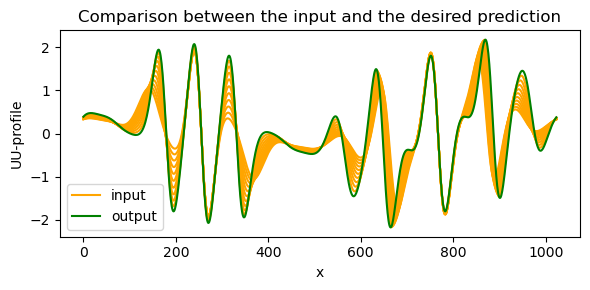

In [5]:
from numpy import random
np.random.seed(42)
k = random.randint( 0 , high = ( t_len - 1 - DT ) , dtype = int )

x_ = IN[k]
x_prime = OUT[k]
comparison = OUT[ k - DT ]

fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 6 , 3 ) )
ax.plot( x_[0] , label = "input", color = "orange")
for i in range( 1 , DT, 1 ):
    ax.plot(x_[i], color = "orange")
ax.plot( x_prime , label = "output" , color = "green")
ax.set_xlabel("x")
ax.set_ylabel("UU-profile")
ax.set_title('Comparison between the input and the desired prediction')

fig.tight_layout()
plt.legend()
plt.show()

Divide the dataset in *training*, *validation* and *test set*.

In [6]:
# Divide the dataset between trining, validation and test sets.
dataset_len = len(IN)
train_len = int(dataset_len  * 0.8)
val_len = int(dataset_len  * 0.1)
test_len = int(dataset_len  * 0.1)

# Random shuffle to select the pairs non-sequentially.
idx = np.random.choice( IN.shape[0] , dataset_len  , replace = False )
idx_train = idx[ 0 : train_len ]
idx_val = idx[ train_len : ( train_len + val_len ) ]
idx_test = idx[ ( train_len + val_len ): ]

# Get the dataset done.
TRAIN_IN = np.take( IN , idx_train , axis = 0)
TRAIN_OUT = np.take( OUT , idx_train , axis = 0)
VAL_IN = np.take( IN , idx_val , axis = 0)
VAL_OUT = np.take( OUT , idx_val , axis = 0)
TEST_IN = np.take( IN , idx_test , axis = 0)
TEST_OUT = np.take( OUT , idx_test , axis = 0)

For CASE 1 the model is a **simple RNN** implemented in Keras; it takes as input the $\Delta j$ time-steps before $j+\Delta j$ and gives as output $uu^{(j)}$.

Define the model.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the number of timesteps, inputs, outputs, and hidden units
num_timesteps = DT
num_inputs = x_len
num_outputs = x_len
hidden_size = 50

# Create a sequential model
model = Sequential()
model.add( SimpleRNN( hidden_size , activation='tanh', input_shape=( num_timesteps , num_inputs ) ) )
model.add( Dense( num_outputs , activation='linear' ) )

# Print the summary of the model
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 simple_rnn (SimpleRNN)      (None, 50)                53750     


 dense (Dense)               (None, 1024)              52224     


Total params: 105,974


Trainable params: 105,974


Non-trainable params: 0


_________________________________________________________________


Define the *optimization algorithm*, the *Loss function*, the *learning rate* and compile the model.

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

OPTIMIZER = Adam(learning_rate = 0.01)
LOSS = MeanSquaredError()

model.compile( optimizer = OPTIMIZER , loss = LOSS )

Train the model.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping( monitor='val_loss' , patience = 5 , min_delta = 1e-10)

H = model.fit( TRAIN_IN , TRAIN_OUT , 
            validation_data = ( VAL_IN , VAL_OUT ) ,
            validation_freq = 1 ,
            epochs = 600 ,
            shuffle = True ,
            callbacks=[callback] ,
            verbose = 0)  

Plot the training history.

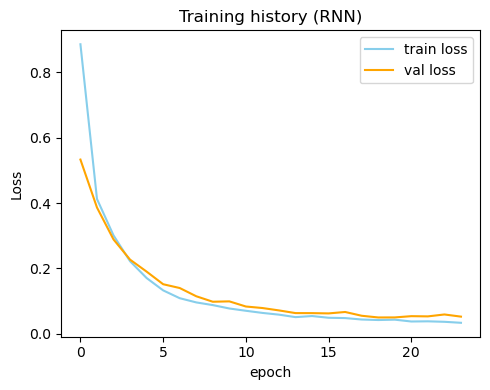

In [10]:
fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 5 , 4 ) )
ax.plot( H.history["loss"] , label = "train loss", color = "skyblue" )
ax.plot( H.history["val_loss"] , label = "val loss", color = "orange" )
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_title('Training history (RNN)')

fig.tight_layout()
plt.legend()
plt.show()

Use the model to make predictions and evaluate them trought the MSE.

In [11]:
TEST_PRED = model.predict(TEST_IN)
TEST_MSE = LOSS(TEST_PRED,TEST_OUT)
TOT_PRED = model.predict(IN)
TOT_MSE = LOSS(TOT_PRED,OUT)

print("\n--->The MSE on the test set is: {:.3f}".format(TEST_MSE.numpy()))
print("--->The MSE on the entire dataset is: {:.3f}".format(TOT_MSE.numpy())+"\n")

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 151ms/step


1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 3ms/step



--->The MSE on the test set is: 0.057
--->The MSE on the entire dataset is: 0.037



Compare the real $uu$ profiles with the predicted $uu$ profiles in a movie. 

In [12]:
fig.clear()
plt.close()
 
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6,3)
 
def animate(i):
    ax.clear()
    ax.plot( x, TOT_PRED[i], label = "prediction", color = "blue" )
    ax.plot( x, OUT[i], label = "real data", color = "red" )
    ax.set_title("RNN vs ODE trajectories")
    ax.set_xlabel("x")
    ax.set_ylabel("uu")
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([-4,4])
    ax.legend(loc="upper right")
plt.close()

tot_frames = TOT_PRED.shape[0]

ani = FuncAnimation( fig, animate, frames=tot_frames, interval=tot_frames)#repeat=False

video_name = "RNN_performance_KS.mp4"
ani.save(video_name, fps=10,  extra_args=['-vcodec', 'libx264'])

In [13]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/7jgMM2sd9lU" title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Link to the video: [Recurrent Neural Network predictions of the Kuramoto-Sivashinsky equation](https://youtu.be/7jgMM2sd9lU)

Plot the prediction of the entire dataset.

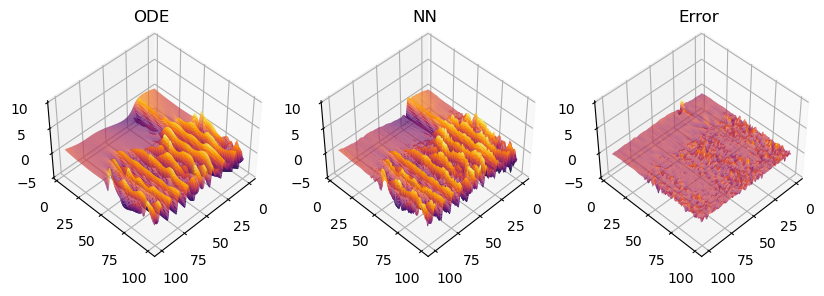

In [14]:
fig.clear()
plt.close()

err = TOT_PRED - uu[DT:]

# Plot the comparison ammong the NN and ODE trajectories.
X , T = np.meshgrid( x , tt )
fig, axes = plt.subplots(1, 3, figsize=( 10 , 3 ) , subplot_kw = { "projection" : "3d" } )
for zz, label, ax in zip( [ uu[DT:] , TOT_PRED, err], ['ODE', 'NN', 'Error'], axes):
    surf = ax.plot_surface( X[DT:] , T[DT:] , zz , cmap = 'inferno' , rstride = 3 , cstride = 3 , antialiased = True )
    ax.set_zlim( -5 , 10 )
    ax.set_title( label )
    ax.view_init( 45 , 45 )
plt.show()

### CASE 2
Create the data pairs.

In [15]:
# Choose a DELTA T (from 0 to 251)
DT_ = 30

# Create the input and output pairs.
IN_ = uu[ :( t_len - DT_ ) , : ] 
OUT_ = uu[ DT_ : (t_len) , : ] 

Plot the data pairs.

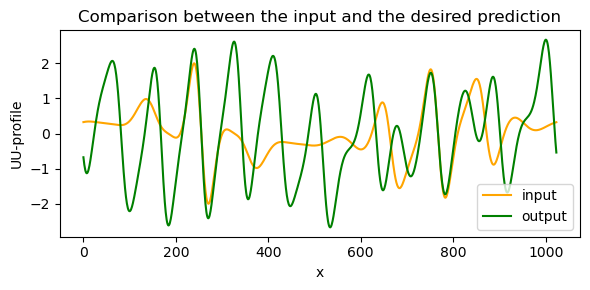

In [16]:
x_ = IN_[100]
x_prime = OUT_[100]
comparison = OUT_[ 100 - DT_ ]

fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 6 , 3 ) )
ax.plot( x_ , label = "input", color = "orange" )
ax.plot( x_prime , label = "output" , color = "green" )
ax.set_xlabel("x")
ax.set_ylabel("UU-profile")
ax.set_title('Comparison between the input and the desired prediction')

fig.tight_layout()
plt.legend()
plt.show()

Divide the data in training, validation and test set.

In [17]:
# Divide the dataset between trining, validation and test sets.
dataset_len_ = len(IN_)
train_len_ = int(dataset_len_  * 0.8)
val_len_ = int(dataset_len_  * 0.1)
test_len_ = int(dataset_len_  * 0.1)

# Random shuffle to select the pairs non-sequentially.
idx_ = np.random.choice( IN_.shape[0] , dataset_len_  , replace = False )
idx_train_ = idx_[ 0 : train_len_ ]
idx_val_ = idx_[ train_len_ : ( train_len_ + val_len_ ) ]
idx_test_ = idx_[ ( train_len_ + val_len_ ): ]

# Get the dataset done.
TRAIN_IN_ = np.take( IN_ , idx_train_ , axis = 0)
TRAIN_OUT_ = np.take( OUT_ , idx_train_ , axis = 0)
VAL_IN_ = np.take( IN_ , idx_val_ , axis = 0)
VAL_OUT_ = np.take( OUT_ , idx_val_ , axis = 0)
TEST_IN_ = np.take( IN_ , idx_test_ , axis = 0)
TEST_OUT_ = np.take( OUT_ , idx_test_ , axis = 0)

For CASE 2 the model is a FFNN implemented in Keras; it takes as input $uu^{(j)}$ and gives as output $uu^{(j+\Delta j)}$.

Define the model.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM

num_inputs_ = x_len
num_outputs_ = x_len

# Create a sequential model
model_ = Sequential()

model_.add( Dense( 512 , activation = 'tanh', input_shape = ( num_inputs_ , ) ) )
model_.add( Dense( num_outputs_ , activation = 'linear' ) )

# Print the summary of the model
model_.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 1024)              525312    


Total params: 1,050,112


Trainable params: 1,050,112


Non-trainable params: 0


_________________________________________________________________


Define the optimization algorithms, the loss, the learning rate and compile the model.

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

OPTIMIZER = Adam(learning_rate = 0.0005)
LOSS = MeanSquaredError()

model_.compile( optimizer = OPTIMIZER , loss = LOSS )

Train the model.

In [20]:
callback_ = EarlyStopping( monitor = 'val_loss' , patience = 10, min_delta = 1e-10 )

H_ = model_.fit( TRAIN_IN_ , TRAIN_OUT_ , 
               validation_data = ( VAL_IN_ , VAL_OUT_ ) ,
               validation_freq = 1 ,
               epochs = 1000 ,
               shuffle = True ,
               callbacks=[callback_] ,
               verbose = 0) 

Plot the training history.

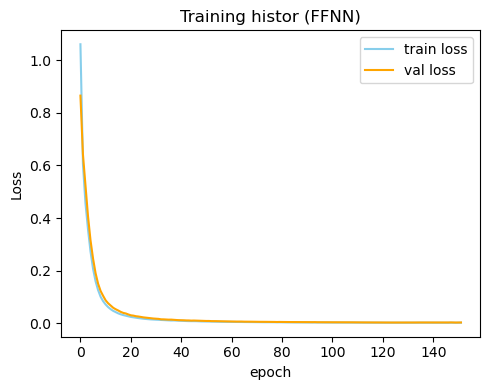

In [21]:
fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 5 , 4 ) )
ax.plot( H_.history["loss"] , label = "train loss", color = "skyblue" )
ax.plot( H_.history["val_loss"] , label = "val loss", color = "orange" )
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_title('Training histor (FFNN)')

fig.tight_layout()
plt.legend()
plt.show()

Use the model to make predictions and the MSE to evaluate them.

In [22]:
TEST_PRED_ = model_.predict(TEST_IN_)
TEST_MSE_ = LOSS(TEST_PRED_,TEST_OUT_)
TOT_PRED_ = model_.predict(IN_)
TOT_MSE_ = LOSS(TOT_PRED_,OUT_)

print("\n--->The MSE on the test set is: {:.3f}".format(TEST_MSE_.numpy()))
print("--->The MSE on the entire dataset is: {:.3f}".format(TOT_MSE_.numpy())+"\n")

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 2ms/step



--->The MSE on the test set is: 0.003
--->The MSE on the entire dataset is: 0.003



Compare the real $uu$ profiles with the predicted $uu$ profiles.

In [23]:
fig.clear()
plt.close()
 
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6,3)
 
def animate(i):
    ax.clear()
    ax.plot( x, TOT_PRED_[i], label = "prediction", color = "blue" )
    ax.plot( x, OUT_[i], label = "real data", color = "red" )
    ax.set_title("FFNN vs ODE trajectories")
    ax.set_xlabel("x")
    ax.set_ylabel("uu")
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([-4,4])
    ax.legend(loc="upper right")
plt.close()

tot_frames = TOT_PRED_.shape[0]

ani = FuncAnimation( fig, animate, frames=tot_frames, interval=tot_frames)#repeat=False

In [24]:
%%HTML

<iframe width="560" height="315" src="https://www.youtube.com/embed/AH57dqqxLCg" title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Link to the video: [Feed Forward Neural Network predictions of the Kuramoto-Sivashinsky equation](https://youtu.be/AH57dqqxLCg)

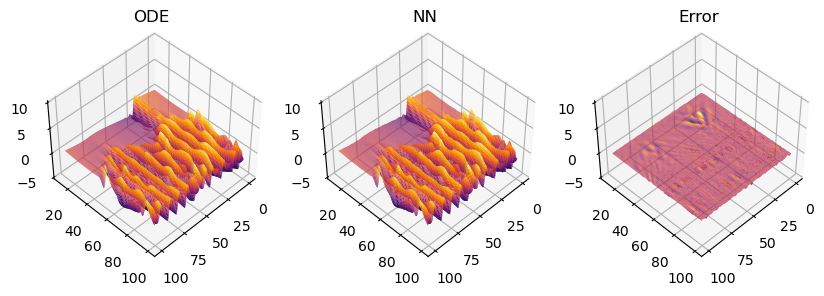

In [25]:
fig.clear()
plt.close()

err = TOT_PRED_ - uu[DT_:]

# Plot the comparison ammong the NN and ODE trajectories.
X , T = np.meshgrid( x , tt )
fig, axes = plt.subplots(1, 3, figsize=( 10 , 3 ) , subplot_kw = { "projection" : "3d" } )
for zz, label, ax in zip( [ uu[DT_:] , TOT_PRED_ , err], ['ODE', 'NN', 'Error'], axes):
    surf = ax.plot_surface( X[DT_:] , T[DT_:] , zz , cmap = 'inferno' , rstride = 3 , cstride = 3 , antialiased = True )
    ax.set_zlim( -5 , 10 )
    ax.set_title( label )
    ax.view_init( 45 , 45 )
plt.show()

In summary the FFNN model worked better than the RNN. This is slightly surprsising as when considering time series one would expect an RNN structure to outperform a simple FFNN.
However RNNs are known for beeing notoriously hard to train as such it could require a lot more experimentaion to get a well performing RNN.

Therefore it is not possible to make general conclusion on the architectures, however it is deemed that the FFNN is easier to work with and therefore is chosen for the next exercises.

## (b) - Time stepping with the NN

```{important} This part exercise was solved in a slightly different way than the original exercise pre-scribed.
At the time the KS-system was not implemented in Python and generating new initial conditions was not an option. 
Therefore as per agreement in class the part exercise was solved by time-marching the predictions of the FFNN in that sense the FFNN is predicting under new conditions each time-step.
Thereby evaluating the models ability to generalize.
```

As the previous model was trained to make larger jumps in time, it is necesarry to train a model that only makes single steps in time.
i.e. input $uu^{(j)}$ and output $uu^{(j+1)}$.

In this way, it is possible to setup a loop where the network takes as input its own output and generates its trajectory.

In [26]:
# divide the dataset between input and output.
IN = uu[ : ( t_len - 1 ) , : ] 
OUT = uu[ 1 : (t_len) , : ] 

# shuffle the dataset.
idx = np.random.choice( IN.shape[0] , IN.shape[0] , replace = False )
IN = np.take( IN , idx , axis = 0)
OUT = np.take( OUT , idx , axis = 0)

In the below cell the model is set up. In the follwing cell the model is trained:

In [27]:
# Define the number of timesteps, inputs, outputs, and hidden units.
num_timesteps = 1
num_inputs = x_len
num_outputs = x_len
hidden_size = 1024

# Create a sequential model.
model = Sequential()
model.add( Dense( hidden_size , activation = 'tanh', input_shape = ( num_inputs , ) ) )
model.add( Dense( num_outputs , activation = 'linear' ) )

# Define the optimizer and the loss function and create a model.
OPTIMIZER = Adam( learning_rate = 1e-4 )
LOSS = MeanSquaredError()
model.compile( optimizer = OPTIMIZER , loss = LOSS )

In [28]:
# Fit the model.
callback = EarlyStopping( monitor = 'loss' , patience = 10 , min_delta = 1e-10 )
H = model.fit( IN.squeeze(), OUT.squeeze(), 
               epochs = 1000 ,
               shuffle = True ,
               callbacks = [callback] ,
               verbose = 0)  

# Compute the network trajectory.
trajectory_evolution = np.zeros( ( t_len , x_len ) )
trajectory_evolution[ 0 , : ] = IN[ 0 ]
APP = trajectory_evolution[ 0 , : ]
for i in range( t_len - 1 ):
    trajectory_evolution[ i , : ] = model.predict( APP[ None , : ] , verbose = 0 )
    APP = trajectory_evolution[ i , : ]

err = trajectory_evolution - uu

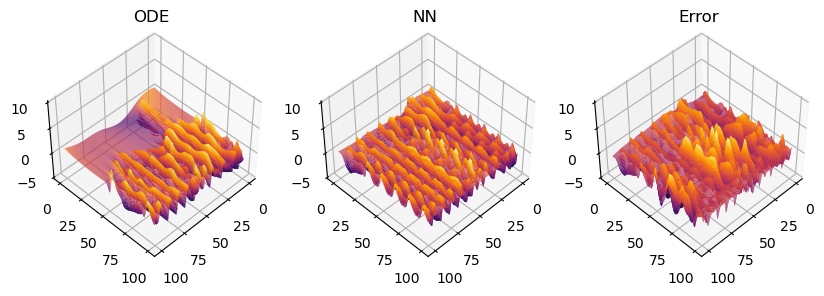

In [29]:
# Plot the comparison ammong the NN and ODE trajectories.
X , T = np.meshgrid( x , tt )
fig, axes = plt.subplots(1, 3, figsize=( 10 , 3 ) , subplot_kw = { "projection" : "3d" } )
for zz, label, ax in zip( [ uu , trajectory_evolution , err], ['ODE', 'NN', 'Error'], axes):
    surf = ax.plot_surface( X , T , zz , cmap = 'inferno' , rstride = 3 , cstride = 3 , antialiased = True )
    ax.set_zlim( -5 , 10 )
    ax.set_title( label )
    ax.view_init( 45 , 45 )
plt.show()

The model is not looking to generalize well. Almost imediately the model starts to make poor predictions and these are then further propogated downstream.
It is expected that better performance can be achieved, however to sufficeintly explore the potential architectrues would require more experimentation than can realistically be expected in an exercise.